In [1]:
from Dataset.dataset import Eve, Flchain, FlchainSub1
import numpy as np
import pandas as pd

from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import pickle
from model import XSurvKMeansRF
import time
import seaborn as sns
import matplotlib.pyplot as plt

import shap

C:\Users\Abd\AppData\Local\conda\conda\envs\hh\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = FlchainSub1('Dataset/flchain.csv')

Dataset Description =======================
Dataset Name: flchain_sub1
Dataset Shape: (7874, 6)
Events: 27.55 %
NaN Values: 2.86 %
Events % in splits: 27.56, 27.56, 27.56, 27.56, 27.51, 



In [3]:
(x_train, ye_train, y_train, e_train,
 x_val, ye_val, y_val, e_val,
 x_test, ye_test, y_test, e_test) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)
 #train_df_orig, val_df_orig, test_df_orig) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)

print('Testing on %d-----------------------------' % 1)
print(x_train.shape, x_val.shape)

Testing on 1-----------------------------
(4724, 4) (1575, 4)


In [4]:
ds.features_names

['age', 'sex', 'creatinine', 'SigmaFLC']

In [5]:
# special for RSF
dt = np.dtype('bool,float')
y_train_surv = np.array([(bool(e), y) for e, y in zip(e_train, y_train)], dtype=dt)
y_val_surv = np.array([(bool(e), y) for e, y in zip(e_val, y_val)], dtype=dt)
y_test_surv = np.array([(bool(e), y) for e, y in zip(e_test, y_test)], dtype=dt)
print(y_train_surv.shape, y_val_surv.shape, y_test_surv.shape)

# # train RSF
# rsf = RandomSurvivalForest(n_estimators=50,
#                            min_samples_split=5,
#                            min_samples_leaf=5,
#                            max_features="sqrt",
#                            oob_score=True,
#                            n_jobs=-1,
#                            random_state=20)
# #rsf.fit(x_train, y_train_surv)

# # special for Cox
# xy_train_df = pd.DataFrame(x_train)
# xy_train_df['T'] = y_train
# xy_train_df['E'] = e_train

# xy_val_df = pd.DataFrame(x_val)
# xy_val_df['T'] = y_val
# xy_val_df['E'] = e_val

# xy_test_df = pd.DataFrame(x_test)
# xy_test_df['T'] = y_test
# xy_test_df['E'] = e_test

# cph = CoxPHFitter(penalizer=500).fit(xy_train_df, 'T', 'E')

cph = CoxPHSurvivalAnalysis(alpha=0.1, n_iter=10000).fit(x_train, y_train_surv)

(4724,) (1575,) (1575,)


In [6]:
cindex_train = cph.score(x_train, y_train_surv)
cindex_val = cph.score(x_val, y_val_surv)
cindex_test = cph.score(x_test, y_test_surv)

In [7]:
#pickle.dump(rsf, open('rsf_model_eve.mdl', 'wb'))
#rsf = pickle.load(open('rsf_model_eve.mdl', 'rb'))

In [8]:
# cindex_train = rsf.score(x_train, y_train_surv)
# cindex_oob = rsf.oob_score_
# cindex_val = rsf.score(x_val, y_val_surv)
# cindex_val_events = rsf.score(x_val[e_val==1], y_val_surv[e_val==1])

print('Train cindex {:.2f}'.format(cindex_train*100))
print('Val cindex {:.2f}'.format(cindex_val*100))
print('Test cindex {:.2f}'.format(cindex_test*100))

Train cindex 79.96
Val cindex 79.40
Test cindex 77.65


In [9]:
yp = -np.dot(x_train, cph.coef_)
concordance_index(y_train, yp, e_train)

0.7996131383259093

In [10]:
ds.features_names

['age', 'sex', 'creatinine', 'SigmaFLC']

In [11]:
cph.coef_

array([ 1.1206438 , -0.14272394, -0.00979367,  0.23323219])

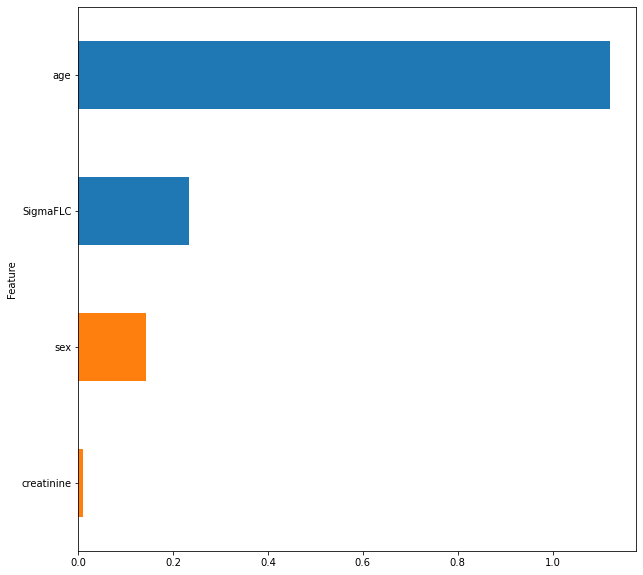

In [12]:
cph_feature_importnce_df = pd.DataFrame(zip(ds.features_names, cph.coef_), columns=['Feature', 'Importance'])
cph_feature_importnce_df.set_index('Feature', inplace=True)

cph_feature_importnce_df['Color'] = cph_feature_importnce_df['Importance'].map(lambda x: 'C0' if x>=0 else 'C1')
cph_feature_importnce_df['Abs_Imp'] = cph_feature_importnce_df['Importance'].abs()

plt.figure(figsize=(10, 10))
cph_feature_importnce_df.sort_values('Abs_Imp')['Abs_Imp'].plot.barh(color=cph_feature_importnce_df.sort_values('Abs_Imp')['Color'])

In [13]:
# special for Cox
xy_train_df = pd.DataFrame(x_train, columns=ds.features_names)
xy_train_df['T'] = y_train
xy_train_df['E'] = e_train

xy_val_df = pd.DataFrame(x_val, columns=ds.features_names)
xy_val_df['T'] = y_val
xy_val_df['E'] = e_val

xy_test_df = pd.DataFrame(x_test, columns=ds.features_names)
xy_test_df['T'] = y_test
xy_test_df['E'] = e_test

cph = CoxPHFitter(penalizer=0.1).fit(xy_train_df, 'T', 'E')


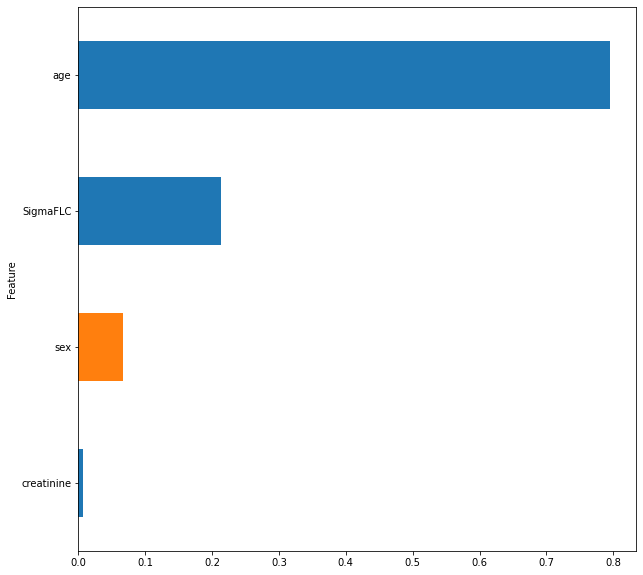

In [14]:
cph_feature_importnce_df = pd.DataFrame(zip(ds.features_names, cph.params_), columns=['Feature', 'Importance'])
cph_feature_importnce_df.set_index('Feature', inplace=True)

cph_feature_importnce_df['Color'] = cph_feature_importnce_df['Importance'].map(lambda x: 'C0' if x>=0 else 'C1')
cph_feature_importnce_df['Abs_Imp'] = cph_feature_importnce_df['Importance'].abs()

plt.figure(figsize=(10, 10))
cph_feature_importnce_df.sort_values('Abs_Imp')['Abs_Imp'].plot.barh(color=cph_feature_importnce_df.sort_values('Abs_Imp')['Color'])

In [15]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4724 total observations, 3423 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 4724
number of events observed = 1301
   partial log-likelihood = -10001.85
         time fit was run = 2022-05-19 12:22:02 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
age          0.79       2.21       0.02             0.75             0.84                 2.11                 2.32
sex         -0.07       0.94       0.02            -0.11            -0.02                 0.89                 0.98
creatinine   0.01       1.01       0.02            -0.03             0.04                 0.97                 1.04
SigmaFLC     0.21       1.24       0.02             0.17             0.25                 1.19                 1.29
               z      p   -log2(p)
covariate                         
age        32.37 <0.005     761.25
sex        -2.77   0.01       7.48
creatinine  0.35   0.73       0.46
SigmaFLC   10.55 <0.005      83.99
---
Concordance = 0.80
Partial AIC = 20011.70
log-likelihood ratio test = 1296.01 on 4 df
-log2(p) of ll-ratio test = 925.53

In [16]:
surv_train = cph.predict_survival_function(x_train)

In [17]:
surv_train

,0,1,2,3,4,5,6,7,8,9,...,4714,4715,4716,4717,4718,4719,4720,4721,4722,4723
0.000000,0.999575,0.998748,0.999545,0.999599,0.998678,0.998878,0.999753,0.999461,0.999554,0.998400,...,0.999811,0.999876,0.998483,0.998930,0.999492,0.999881,0.999835,0.999575,0.999094,0.999809
0.013848,0.999149,0.997491,0.999088,0.999196,0.997351,0.997752,0.999504,0.998920,0.999105,0.996795,...,0.999622,0.999752,0.996962,0.997855,0.998983,0.999762,0.999669,0.999149,0.998185,0.999617
0.019583,0.999006,0.997071,0.998935,0.999062,0.996908,0.997376,0.999421,0.998740,0.998955,0.996259,...,0.999558,0.999711,0.996454,0.997496,0.998812,0.999722,0.999614,0.999006,0.997881,0.999553
0.023985,0.998721,0.996232,0.998630,0.998792,0.996022,0.996624,0.999255,0.998378,0.998656,0.995188,...,0.999431,0.999628,0.995437,0.996778,0.998472,0.999643,0.999503,0.998721,0.997273,0.999425
0.027695,0.998435,0.995392,0.998324,0.998523,0.995135,0.995871,0.999089,0.998016,0.998355,0.994116,...,0.999304,0.999544,0.994421,0.996060,0.998131,0.999563,0.999392,0.998436,0.996665,0.999296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.992010,0.695232,0.342293,0.677447,0.709522,0.322434,0.382745,0.809282,0.630696,0.682466,0.254163,...,0.850854,0.899645,0.272919,0.400006,0.647699,0.903506,0.868266,0.695330,0.460490,0.849206
0.992687,0.695232,0.342293,0.677447,0.709522,0.322434,0.382745,0.809282,0.630696,0.682466,0.254163,...,0.850854,0.899645,0.272919,0.400006,0.647699,0.903506,0.868266,0.695330,0.460490,0.849206
0.995772,0.695232,0.342293,0.677447,0.709522,0.322434,0.382745,0.809282,0.630696,0.682466,0.254163,...,0.850854,0.899645,0.272919,0.400006,0.647699,0.903506,0.868266,0.695330,0.460490,0.849206
0.996350,0.695232,0.342293,0.677447,0.709522,0.322434,0.382745,0.809282,0.630696,0.682466,0.254163,...,0.850854,0.899645,0.272919,0.400006,0.647699,0.903506,0.868266,0.695330,0.460490,0.849206


In [18]:
np.array(surv_train.index)

array([0.        , 0.01384755, 0.01958339, ..., 0.99577248, 0.99634999,
       1.        ])

In [19]:
surv_train = cph.predict_survival_function(x_train)
event_times = np.array(surv_train.index) #cph.baseline_survival_.x

surv_train = surv_train.values.transpose() #np.array([s.y for s in surv_train])

surv_val = cph.predict_survival_function(x_val).values.transpose()
#surv_val = np.array([s.y for s in surv_val])

surv_test = cph.predict_survival_function(x_test).values.transpose()
#surv_test = np.array([s.y for s in surv_test])



#Explanation
xte_data = (x_train, y_train, e_train,
            x_val, y_val, e_val,
            x_test, y_test, e_test)

survival_curves = (surv_train, surv_val, surv_test)

In [20]:
# surv_train = cph.predict_survival_function(x_train)
# surv_train = np.array([s.y for s in surv_train])

# surv_val = cph.predict_survival_function(x_val)
# surv_val = np.array([s.y for s in surv_val])

# surv_test = cph.predict_survival_function(x_test)
# surv_test = np.array([s.y for s in surv_test])

# event_times = cph.baseline_survival_.x

# #Explanation
# xte_data = (x_train, y_train, e_train,
#             x_val, y_val, e_val,
#             x_test, y_test, e_test)

# survival_curves = (surv_train, surv_val, surv_test)

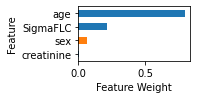

In [21]:
plt.figure(figsize=(2, 1))
cph_feature_importnce_df.sort_values('Abs_Imp')['Abs_Imp'].plot.barh(color=cph_feature_importnce_df.sort_values('Abs_Imp')['Color'])
plt.xlabel('Feature Weight')
plt.savefig('Results/flchain_Sub1_cph/flchain_sub1_cox_w.pdf', format='pdf', bbox_inches='tight')

shape: 2270


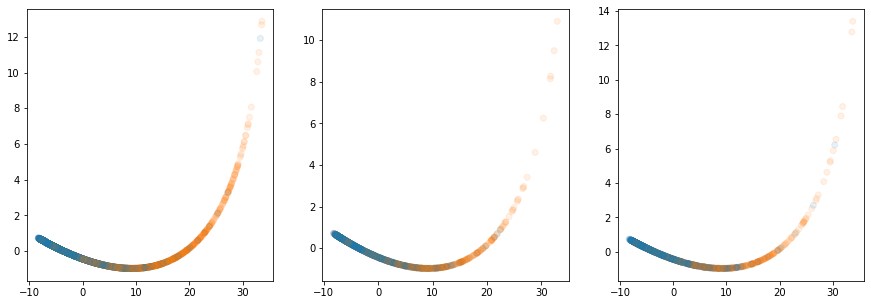

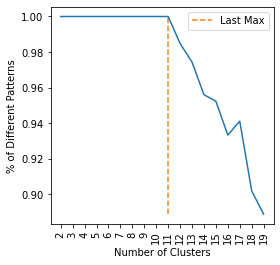

<Figure size 360x360 with 0 Axes>

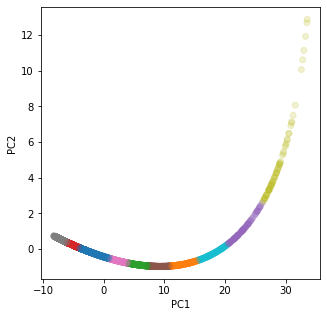

<Figure size 360x360 with 0 Axes>

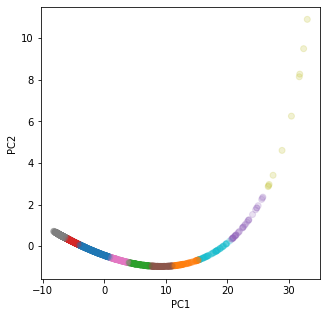

<Figure size 360x360 with 0 Axes>

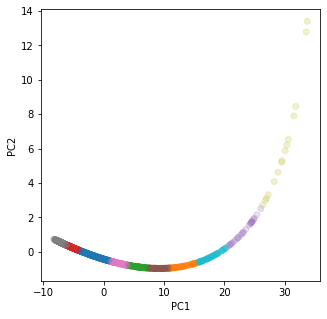

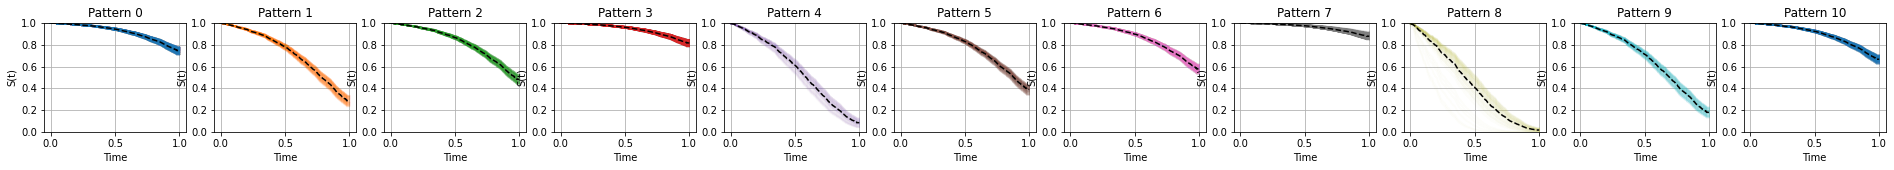

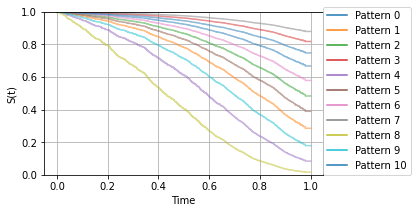

In [22]:
explainer = XSurvKMeansRF(prefix_name='flchain_Sub1_cph', max_k=20, z_explained_variance_ratio_threshold=0.99, curves_diff_significance_level=0.05)
explainer.fit(xte_data=xte_data, survival_curves=survival_curves, event_times=event_times)#, pretrained_clustering_model="clustering_model_eve_9_20220223-152051.mdl", k=9)

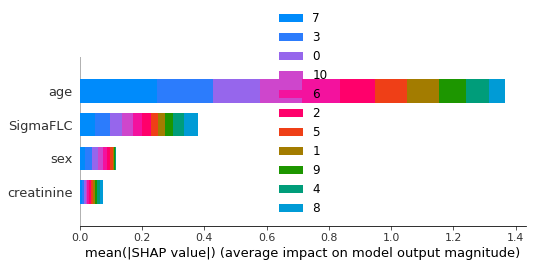

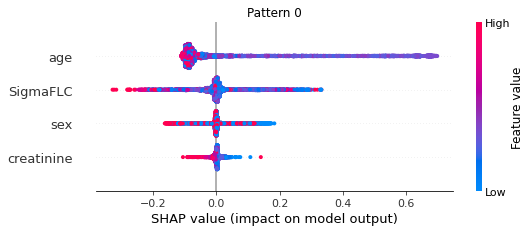

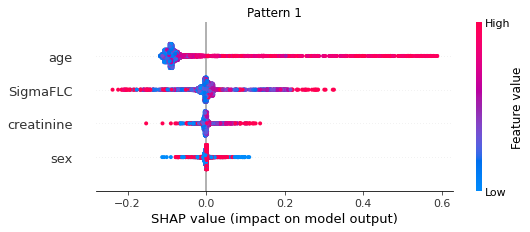

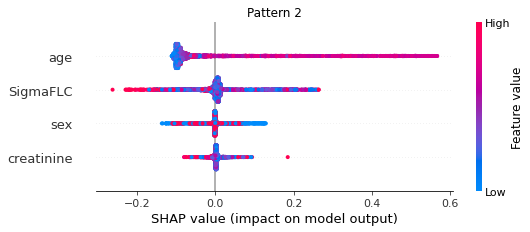

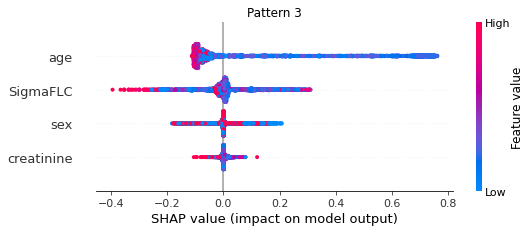

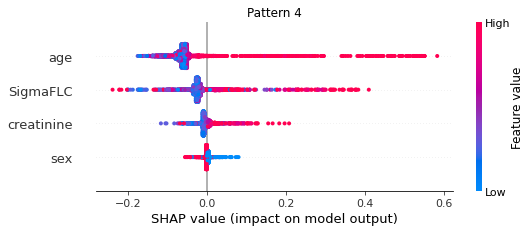

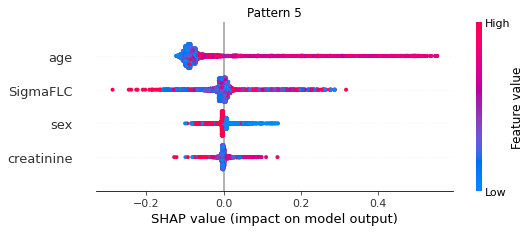

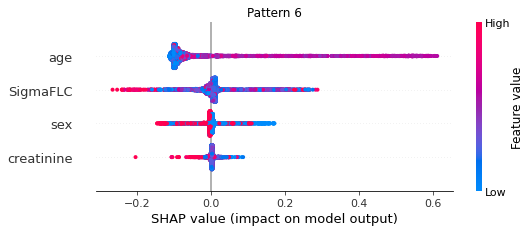

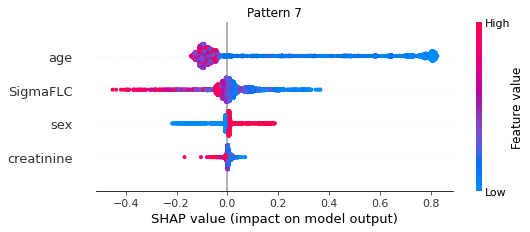

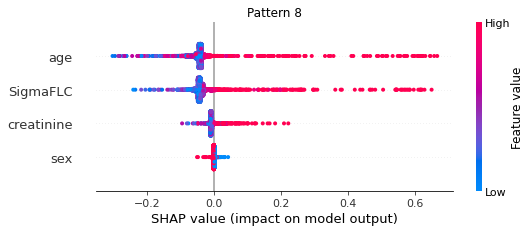

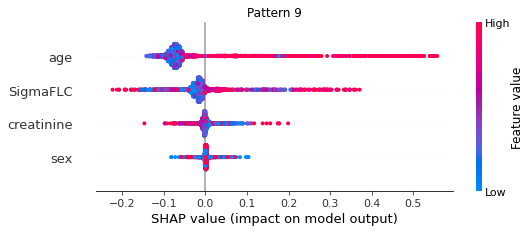

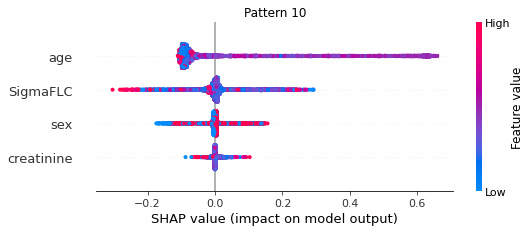

In [22]:
shap_values_train = explainer.explain(x=x_train, features_names_list=ds.features_names, suffex='train')

In [23]:
risk_group = 8

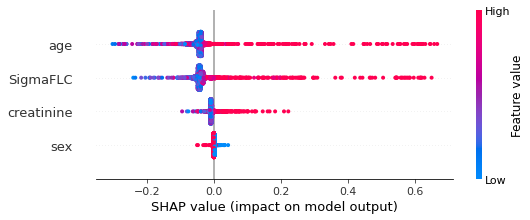

In [24]:
shap.summary_plot(explainer.shap_values[risk_group], x_train, feature_names=ds.features_names, show=False)

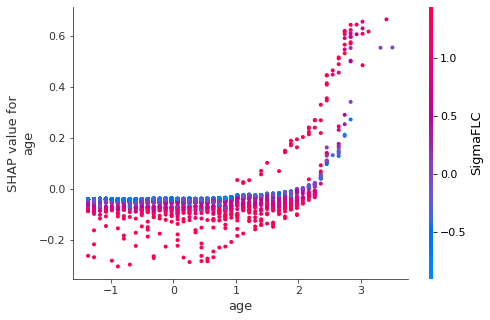

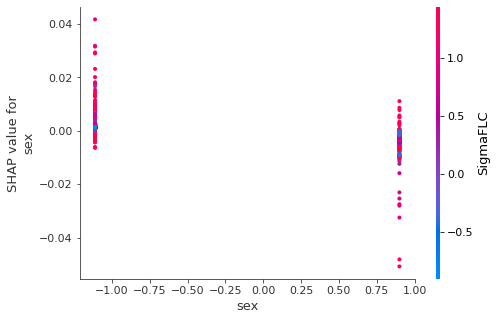

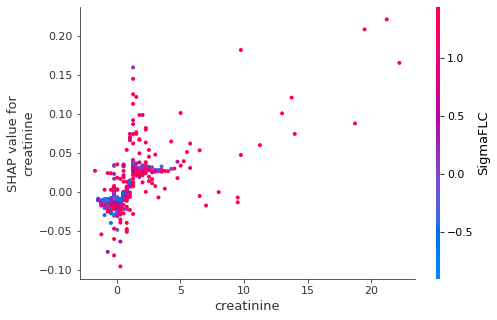

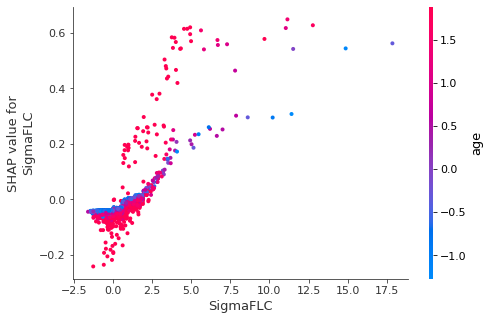

In [25]:
for i in range(len(ds.features_names)):
    shap.dependence_plot(i, explainer.shap_values[risk_group], x_train, feature_names=ds.features_names)

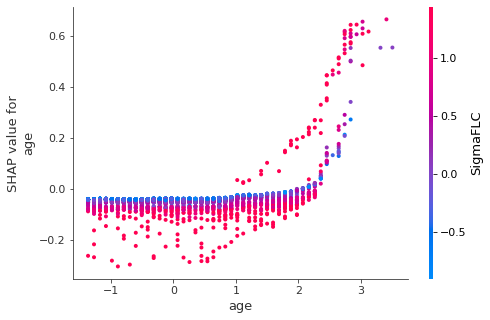

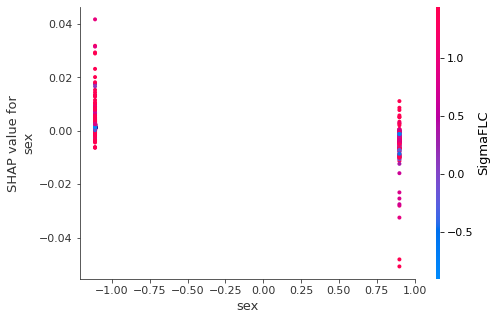

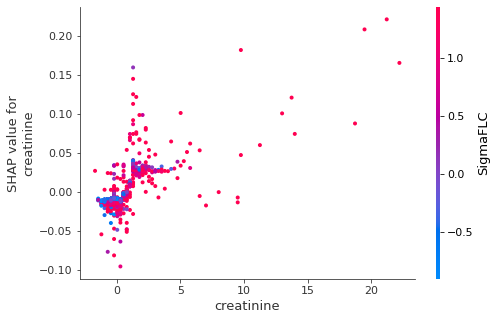

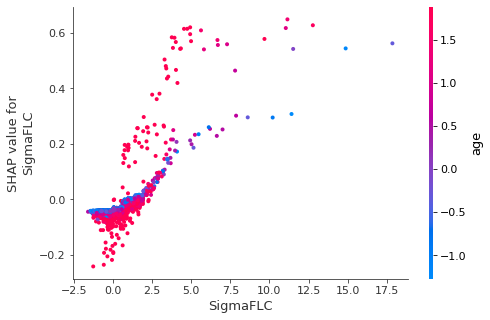

In [26]:
for i in range(len(ds.features_names)):
    shap.dependence_plot(i, explainer.shap_values[risk_group], x_train, feature_names=ds.features_names, show=False)
    plt.savefig(f"Results/flchain_sub1_cph/{ds.features_names[i]}.pdf")

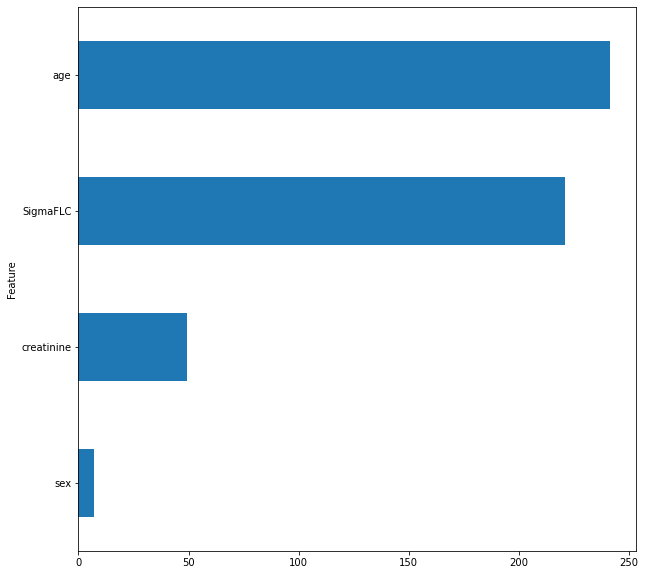

In [27]:
feature_importnce_df = pd.DataFrame(zip(ds.features_names, np.abs(explainer.shap_values[risk_group]).sum(axis=0)), columns=['Feature', 'Importance'])
feature_importnce_df.set_index('Feature', inplace=True)

feature_importnce_df['Color'] = feature_importnce_df['Importance'].map(lambda x: 'C0' if x>=0 else 'C1')
feature_importnce_df['Abs_Imp'] = feature_importnce_df['Importance'].abs()

plt.figure(figsize=(10, 10))
feature_importnce_df.sort_values('Abs_Imp')['Abs_Imp'].plot.barh(color=feature_importnce_df.sort_values('Abs_Imp')['Color'])

In [28]:
#shap_values_val = explainer.explain(x=x_val, features_names_list=ds.features_names, suffex='val')

In [29]:
#shap_values_test = explainer.explain(x=x_test, features_names_list=ds.features_names, suffex='test')